In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS

In [2]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))
        
def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Load data

In [24]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/distance_frame.pkl")

In [25]:
model_frame = model_skeleton.set_index(["origin","status"])

In [26]:
reference_distances = model_frame.loc[("unpermuted","original"),"all_distances"]

In [27]:
distances = model_frame["all_distances"]

In [28]:
!pwd

/home/jakobpp/BayesianGEM/code


### Visualize particle population

In [29]:
unique_origins = model_frame.index.get_level_values("origin").unique()

In [30]:
combined_df_metadata = load_pickle("../results/permuted_smcabc_res/combined_df_metadata.pkl")

In [31]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


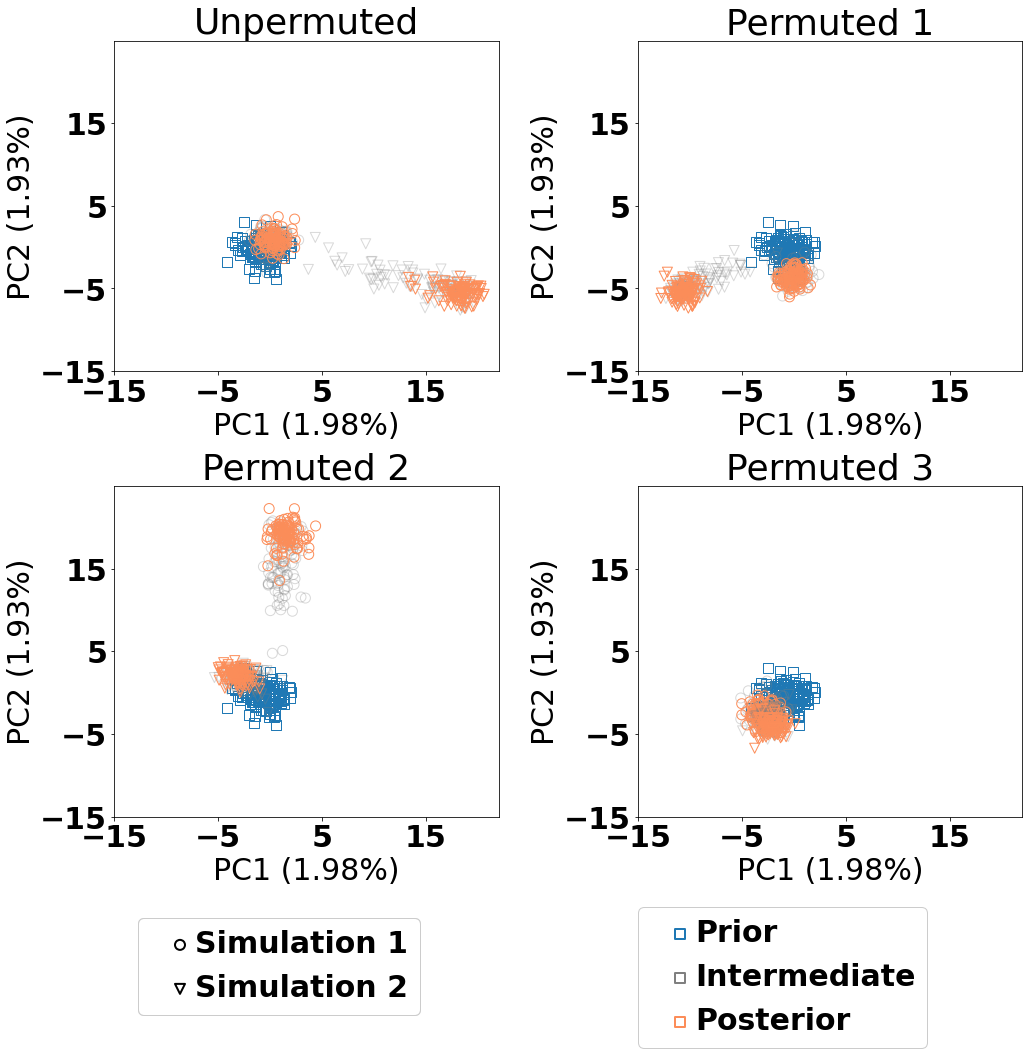

In [32]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-15,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-15,22))
    plt.ylim((-15,25))
    plt.title(proper_names[origin])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc=(-1.3,-.6), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
# plt.savefig("../figures/pca.png",dpi=300)
plt.show()

In [33]:
this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}

In [34]:
len(this_idxs["Posterior"])

5938

## $R^2$ convergence plots

In [35]:
def plot_convergence_inner(distances, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    r2s_history = -np.array(distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(distances):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

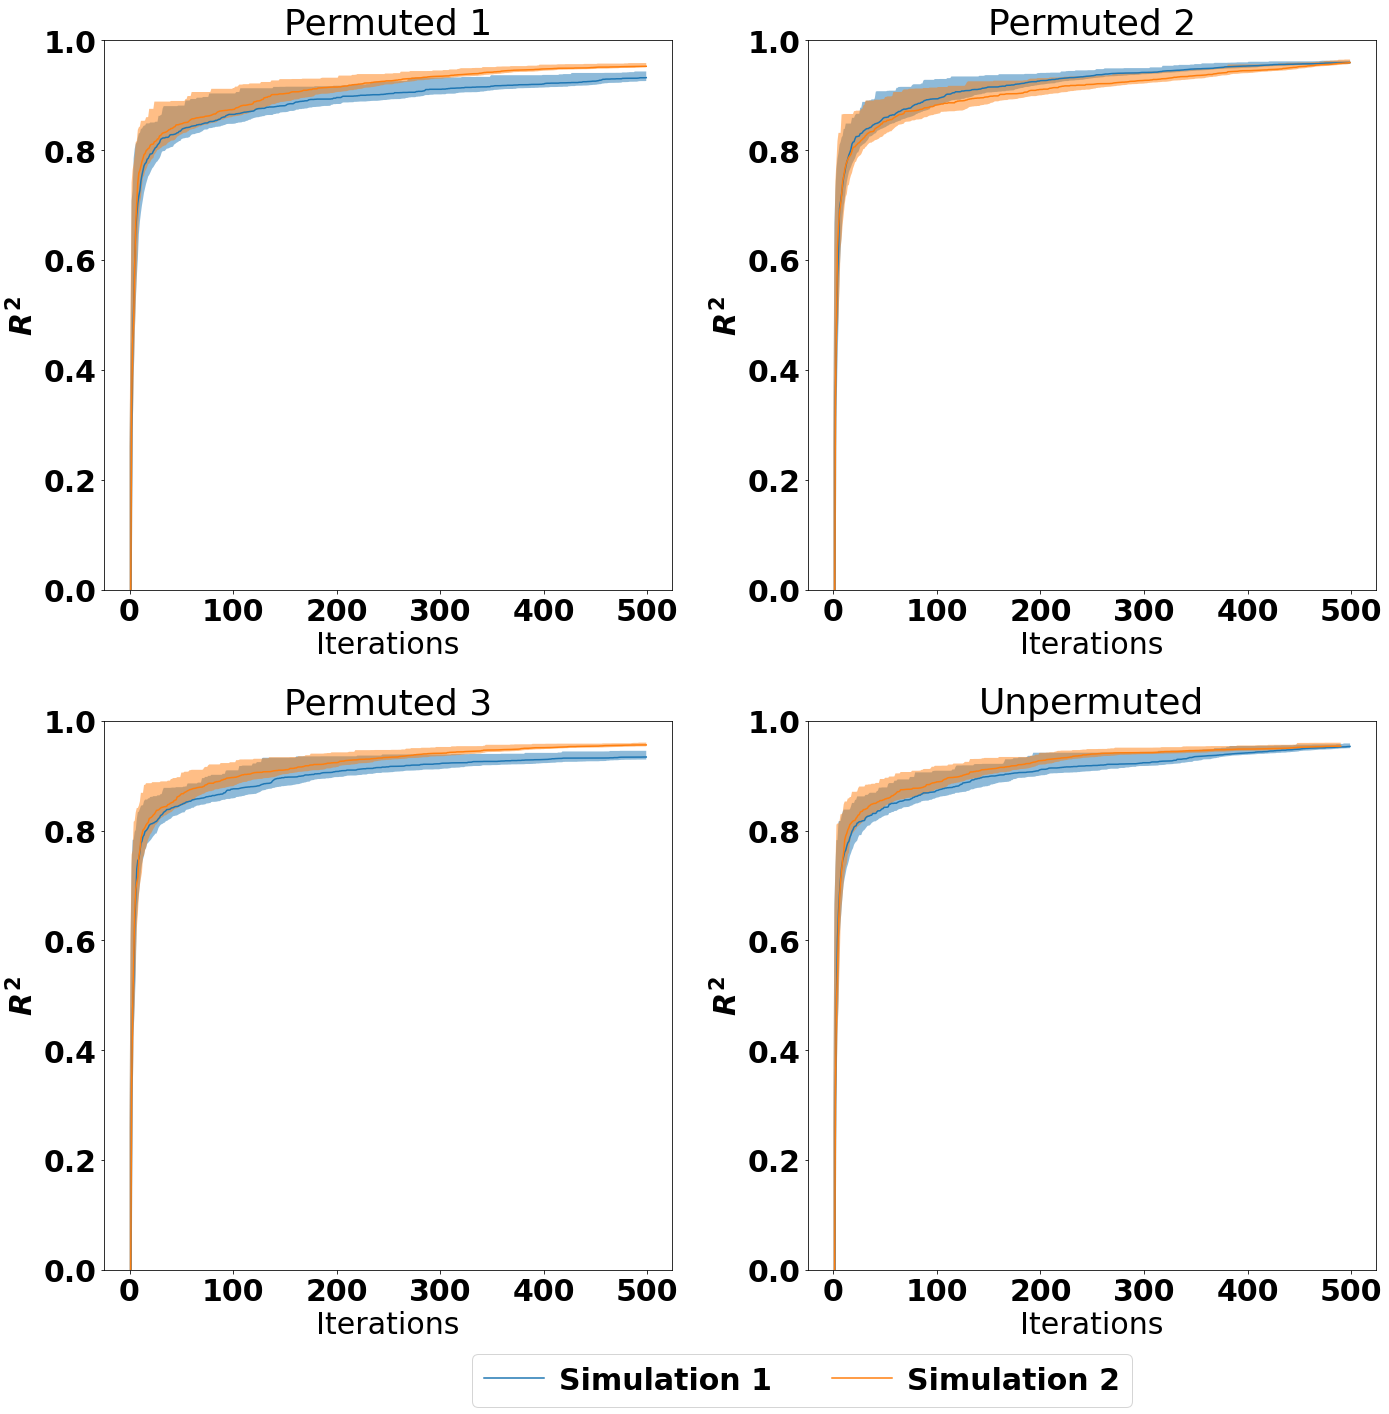

In [36]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["all_distances"].groupby("origin"):
    plt.subplot(2,2,i)
    origin_distances = series[index]
    # Simulation 1
    original_distances = origin_distances["original"]
    # Simulation 2
    replicate_distances = origin_distances["replicate"]
    plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
    if i==4:
        handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
    plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
# plt.savefig("../figures/R2.pdf")
plt.show()

## Create integrated plot for Unpermuted and Permuted 1

In [14]:
reduced_pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_reduced_ordination.pkl")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(63139,)
(61724,)
(62675,)
(62990,)


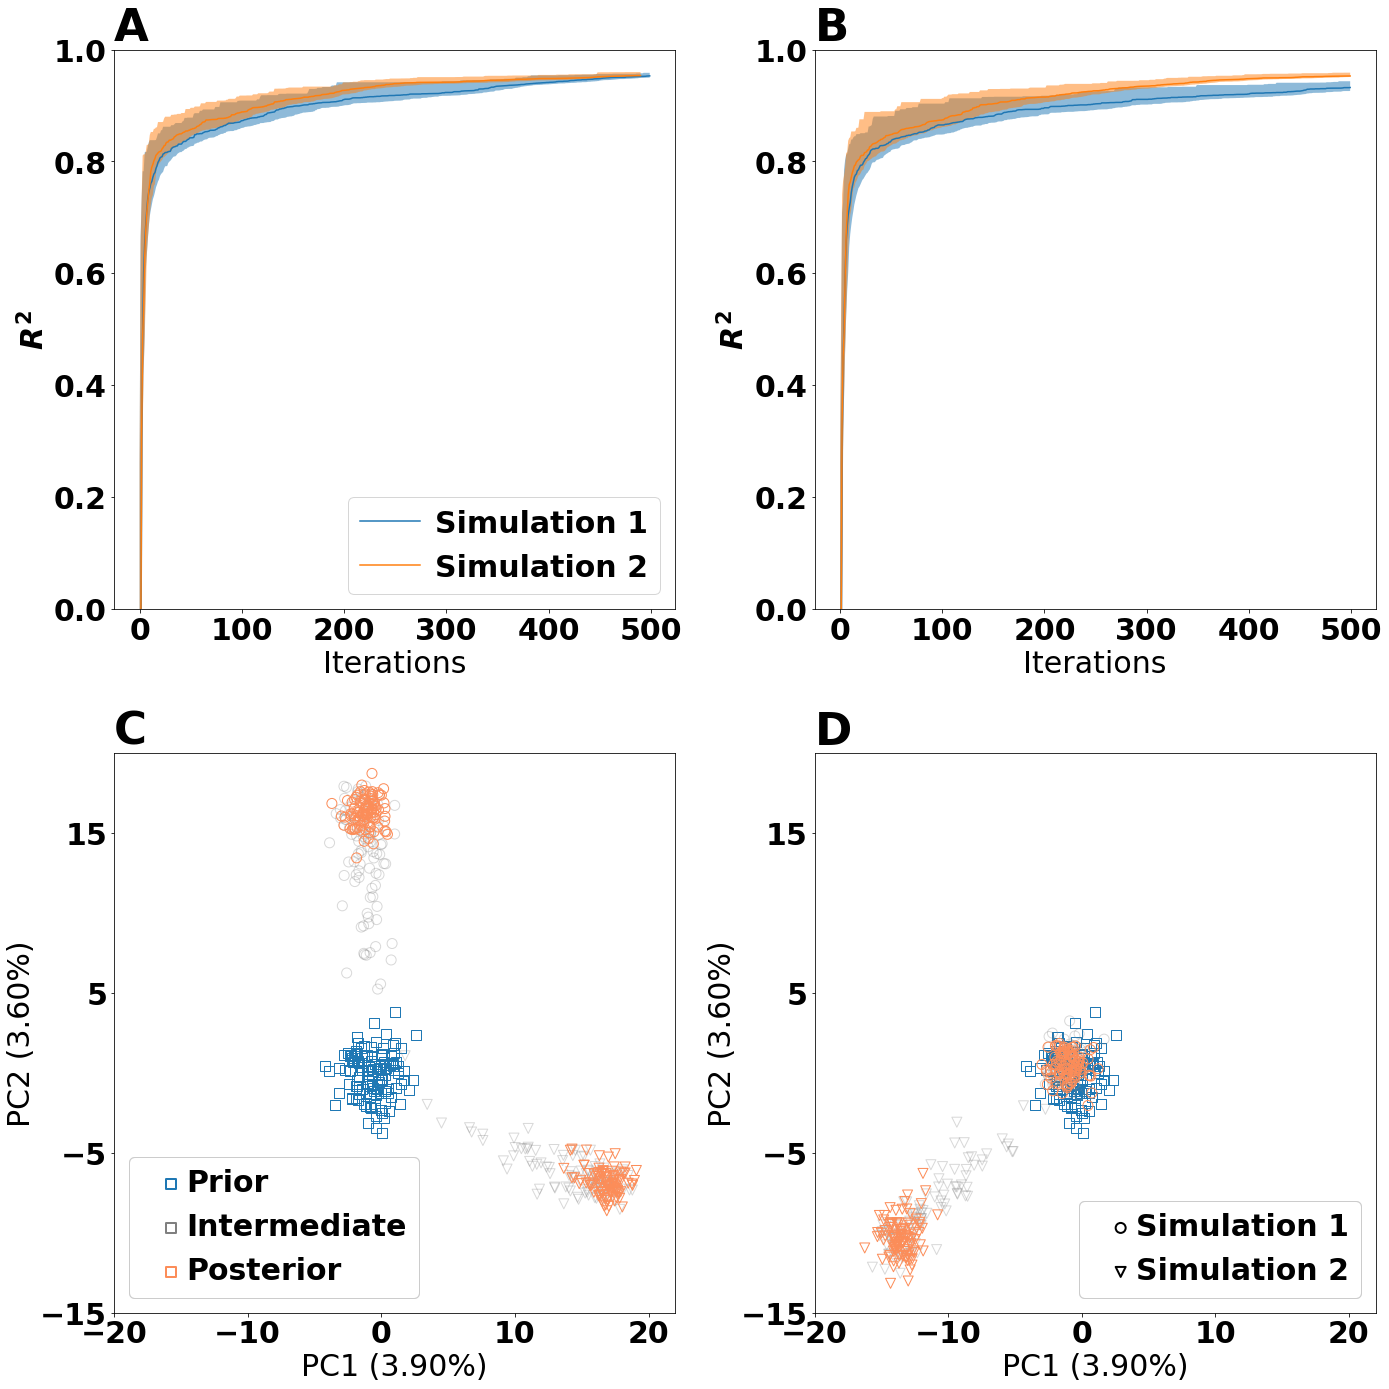

In [15]:
thinning_rng = np.random.default_rng(8049)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
plt.figure(figsize=(20,20))
i=2
for index, series in model_frame.query("origin in ('unpermuted','permuted_0')")["all_distances"].groupby("origin"):
    plt.subplot(2,2,i)
    origin_distances = series[index]
    # Simulation 1
    original_distances = origin_distances["original"]
    # Simulation 2
    replicate_distances = origin_distances["replicate"]
    plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
    if i==1:
        plt.legend(loc="lower right",handletextpad=0.5)
        # handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title("A" if index=="unpermuted" else "B",loc="left",fontsize=45,fontweight="bold")
    i -= 1
    plt.tight_layout()
    
PCS, EV = reduced_pca_ordination
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
i=3
for origin in ["unpermuted","permuted_0"]:
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-20,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-20,22))
    plt.ylim((-15,20))
    plt.title("C" if origin=="unpermuted" else "D",loc="left",fontsize=45,fontweight="bold")
    if origin == "unpermuted":
        legend_period = plt.legend(handles_period, all_periods, loc="lower left", framealpha=1, handletextpad=-.5)
        plt.gca().add_artist(legend_period)
    else:
        legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc="lower right", framealpha=1,handletextpad=-.5)
        plt.gca().add_artist(legend_status)
    plt.tight_layout()

# plt.savefig("../figures/bayesian_fig.png",dpi=300)
plt.show()

# Results of evolutionary algorithm

In [172]:
evo_truncation_model_frame = load_pickle("../results/evo_truncation/distance_frame.pkl")
evo_tournament_model_frame = load_pickle("../results/evo_tournament/distance_frame.pkl")

In [173]:
evo_truncation_model_frame

,num_elites,simulation,outfile,random_seed,all_distances,reduced_distances,population
0,16,0,../results/evo_truncation/smcevo_gem_truncatio...,41860,"[0.3173314277339649, 2.3770669401281235, 0.116...","[0.06699424889427358, 3.0475486849397684, -0.0...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
1,16,1,../results/evo_truncation/smcevo_gem_truncatio...,96913,"[0.11201499198815164, 929469561389.6587, 0.112...","[-0.011343829246549364, 1394204342084.0327, -0...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
2,32,0,../results/evo_truncation/smcevo_gem_truncatio...,6001,"[0.11690237306161162, 0.11690237306161162, 464...","[-0.011343829246500625, -0.011343829246500625,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
3,32,1,../results/evo_truncation/smcevo_gem_truncatio...,77881,"[0.10191089569131113, 0.24014630773046253, 0.2...","[-0.03383104530195369, -0.01134382924654026, -...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
4,64,0,../results/evo_truncation/smcevo_gem_truncatio...,37828,"[464735028817.38965, 0.2888640210208636, 0.112...","[697102543225.6263, -0.023134604320474594, -0....","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
5,64,1,../results/evo_truncation/smcevo_gem_truncatio...,59502,"[0.11808738463149238, 0.1952030620036109, 0.12...","[-0.011343829246514614, -0.16518142473416048, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
6,128,0,../results/evo_truncation/smcevo_gem_truncatio...,24830,"[0.11590416074821885, 0.05657559095252229, 0.1...","[-0.005510076106451323, -0.09450293079998795, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
7,128,1,../results/evo_truncation/smcevo_gem_truncatio...,59462,"[0.23841160183349955, 0.07554055360069567, 0.2...","[-0.0113438292465452, -0.06605548682773277, -0...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


In [174]:
evo_tournament_model_frame

,locality,simulation,outfile,random_seed,all_distances,reduced_distances,population
0,1,0,../results/evo_tournament/smcevo_gem_tournamen...,41860,"[0.35013493511004196, 2.3770669401281235, 0.11...","[0.06699424945845633, 3.0475486849397684, -0.0...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
1,1,1,../results/evo_tournament/smcevo_gem_tournamen...,96913,"[0.11201499198816, 929469561389.569, 0.1120149...","[-0.01134382924653704, 1394204342083.8967, -0....","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
2,64,0,../results/evo_tournament/smcevo_gem_tournamen...,6001,"[0.11201499198815523, 0.11201499198815523, 464...","[-0.011343829246543646, -0.011343829246543646,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
3,64,1,../results/evo_tournament/smcevo_gem_tournamen...,77881,"[0.09702351461790067, 0.11201499198816973, 0.1...","[-0.033831045301925045, -0.011343829246520554,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
4,128,0,../results/evo_tournament/smcevo_gem_tournamen...,37828,"[464735028817.4033, 0.10588322249004929, 0.202...","[697102543225.6469, -0.023143542339139844, -0....","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
5,128,1,../results/evo_tournament/smcevo_gem_tournamen...,59502,"[0.11201499198817615, 0.013053605833215095, 0....","[-0.011343829246513837, -0.16518142452042833, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
6,256,0,../results/evo_tournament/smcevo_gem_tournamen...,24830,"[0.1170891723373918, 0.058310296849452735, 0.1...","[-0.005510076077526238, -0.09450293080003536, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
7,256,1,../results/evo_tournament/smcevo_gem_tournamen...,59462,"[0.11863707895856646, 0.08334765195744487, 0.1...","[-0.011343829246506232, -0.06605548710302184, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


In [153]:
def plot_convergence_evo(distances, maxiter, populations, label = None):
    distance_array = -np.array(distances)
    yp = np.vstack([np.percentile(distance_array[population],[5,50,95]) for population in populations[0:maxiter]])
    plt.plot(np.arange(yp.shape[0]),yp[:,1], label = label)
    plt.fill_between(np.arange(yp.shape[0]),yp[:,0],yp[:,2],alpha=0.5)

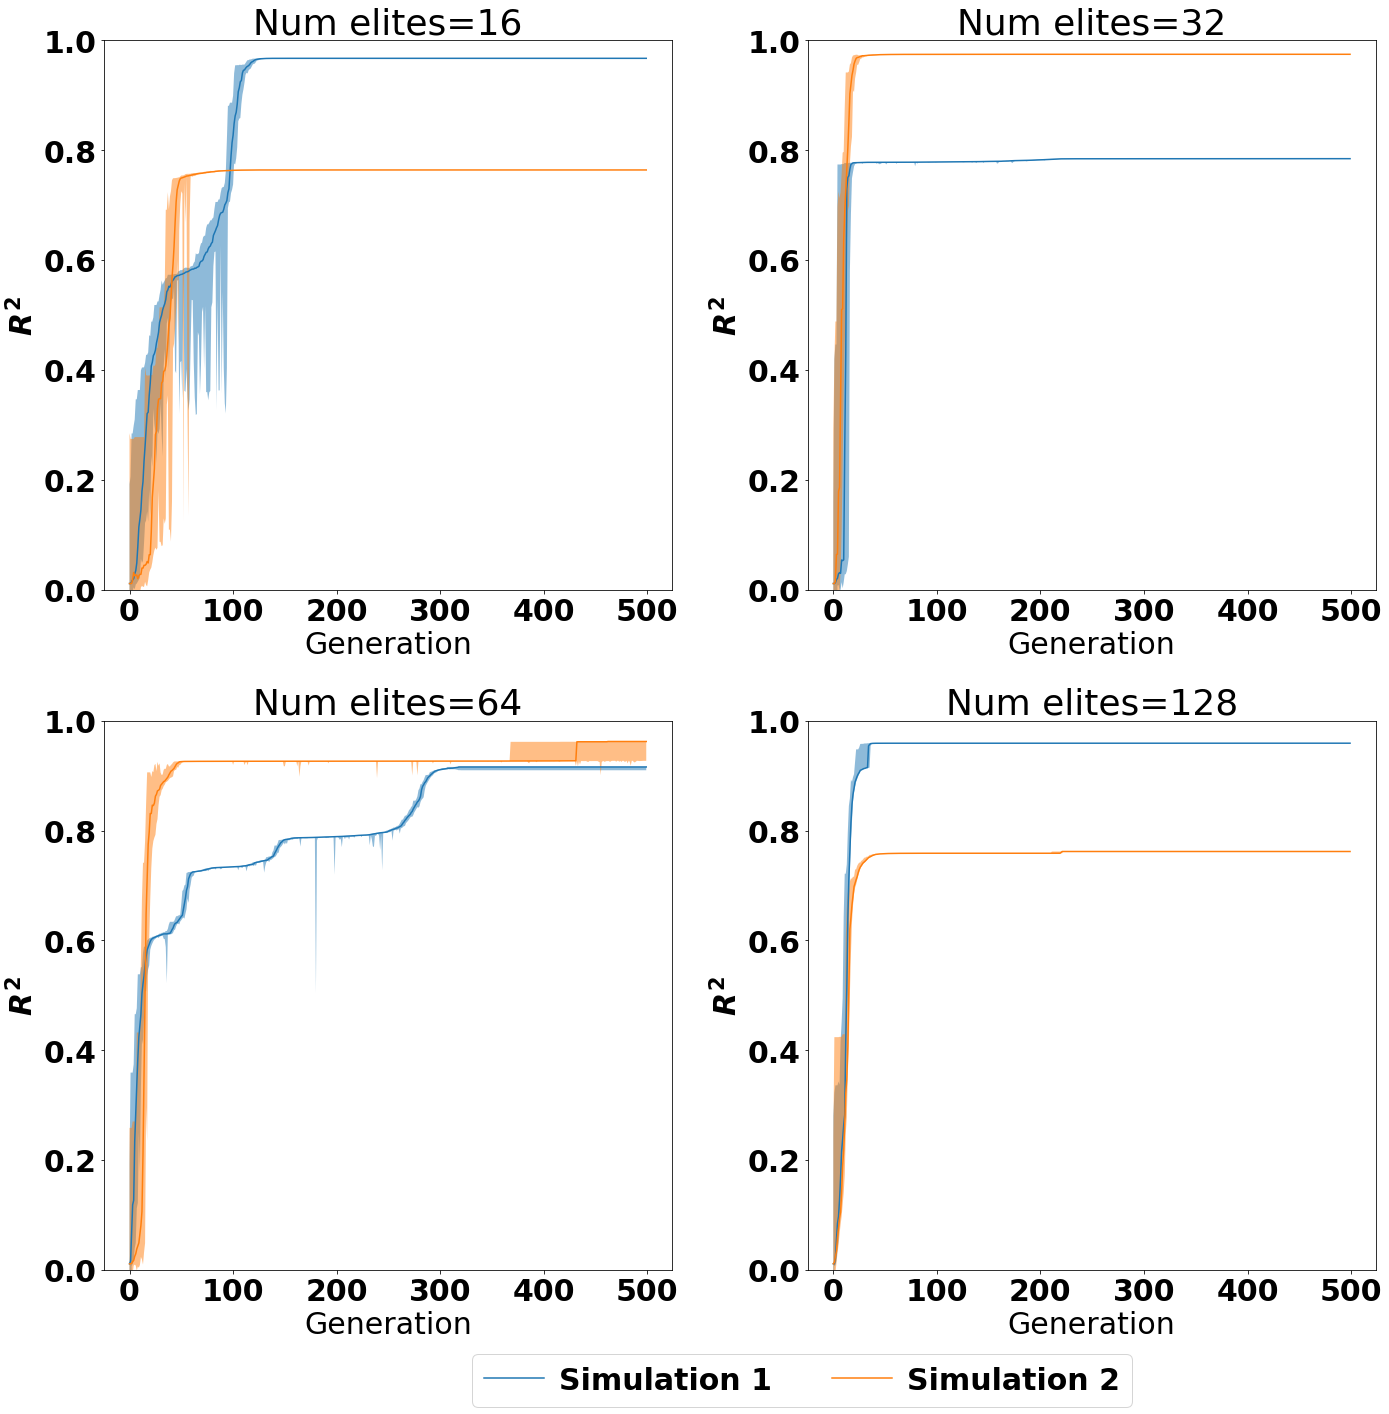

In [178]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
maxiter = 500
num_elites_values = np.sort(np.unique(evo_truncation_model_frame["num_elites"]))
subplot_order = {num_elites: i for num_elites, i in zip(num_elites_values,range(1,5))}
plt.figure(figsize=(20,20))
for _, entry in evo_truncation_model_frame.iterrows():
    num_elites = entry["num_elites"]
    i = subplot_order[num_elites]
    simulation = entry["simulation"]
    populations = entry["population"]
    # plt.subplot(2,2,i)
    distances = entry["reduced_distances"]
    plt.subplot(2,2,i)
    plot_convergence_evo(distances,maxiter=500,populations=populations, label = f'Simulation {simulation + 1}')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Generation')
    plt.ylabel('$R^2$')
    plt.title(f"Num elites={num_elites}")
    plt.tight_layout()
plt.subplots_adjust(bottom=0.10)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
plt.savefig("../figures/truncation_R2.png",dpi=300)
plt.show()

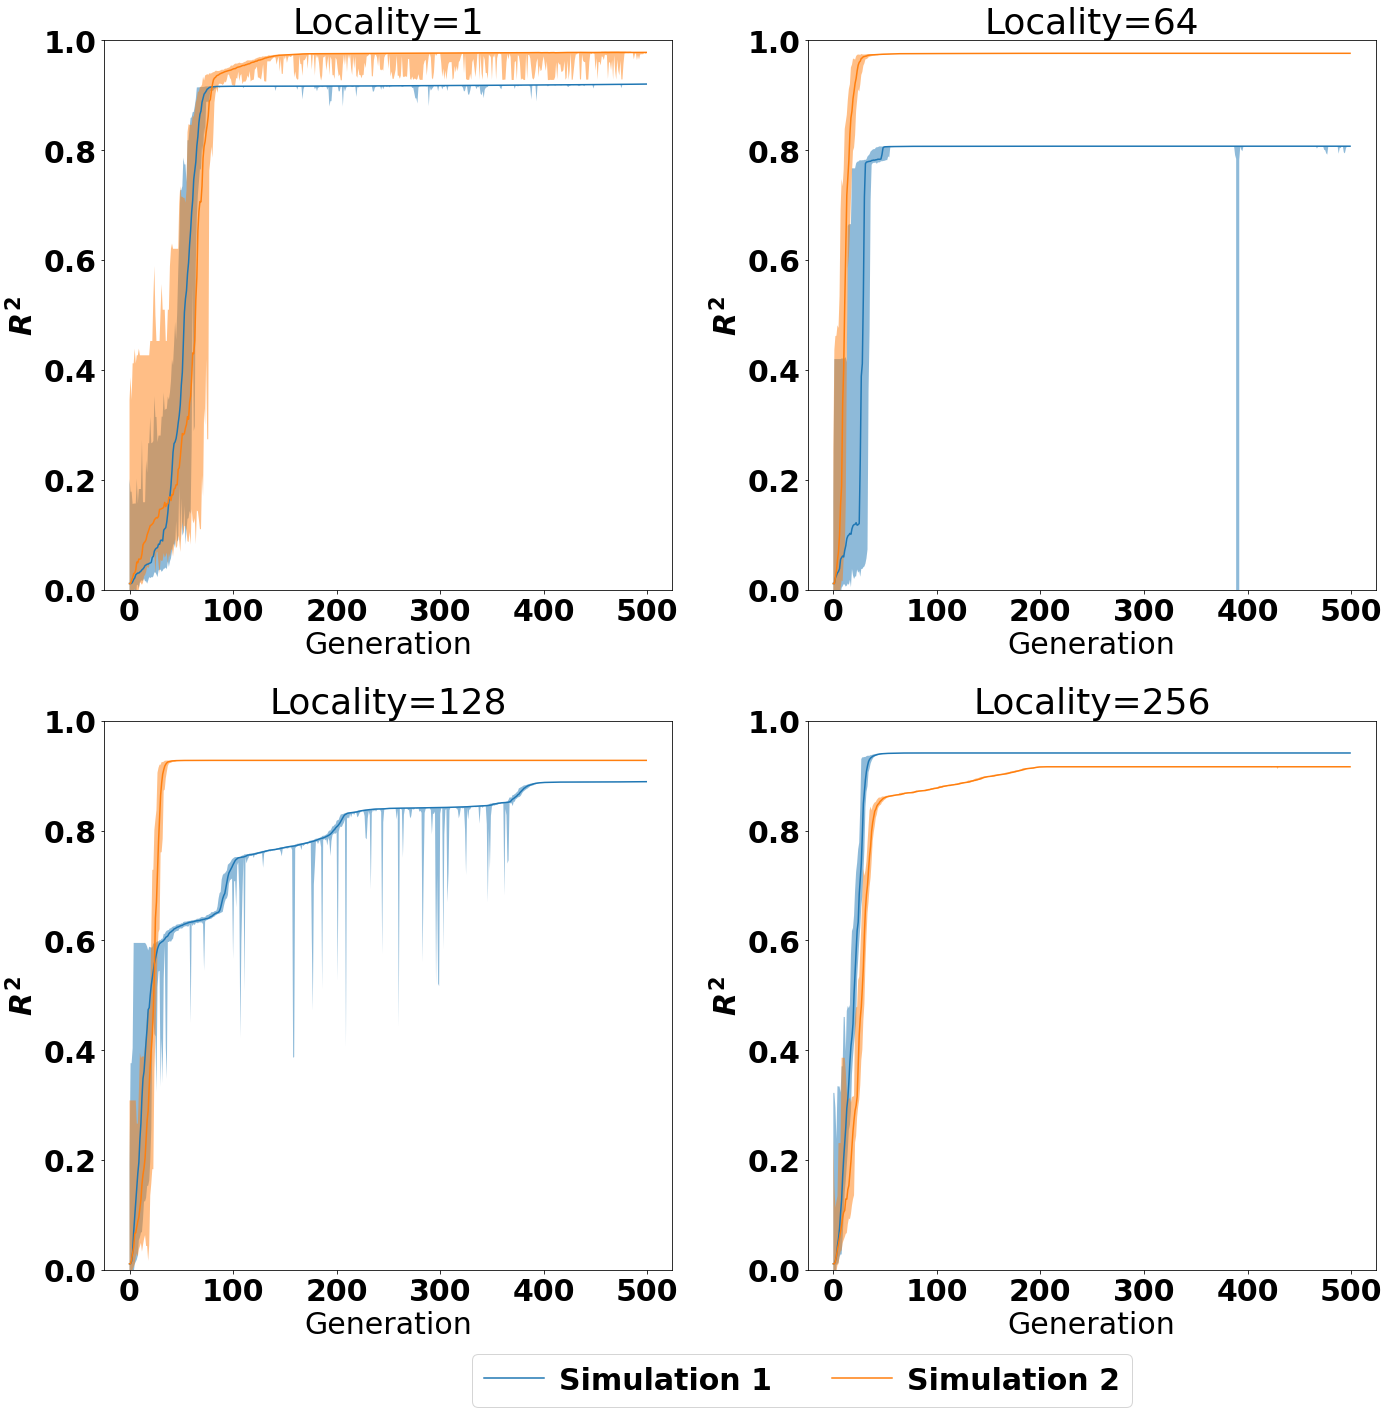

In [177]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
maxiter = 500
locality_values = np.sort(np.unique(evo_tournament_model_frame["locality"]))
subplot_order = {locality: i for locality, i in zip(locality_values,range(1,5))}
plt.figure(figsize=(20,20))
for _, entry in evo_tournament_model_frame.iterrows():
    locality = entry["locality"]
    i = subplot_order[locality]
    simulation = entry["simulation"]
    populations = entry["population"]
    # plt.subplot(2,2,i)
    distances = entry["reduced_distances"]
    plt.subplot(2,2,i)
    plot_convergence_evo(distances,maxiter=500,populations=populations, label = f'Simulation {simulation + 1}')
    # handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Generation')
    plt.ylabel('$R^2$')
    plt.title(f"Locality={locality}")
    plt.tight_layout()
plt.subplots_adjust(bottom=0.10)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
plt.savefig("../figures/tournament_R2.png",dpi=300)
plt.show()

In [55]:
evo_PCS,evo_EV = load_pickle("../results/permuted_smcevo_res/pca_full_ordination.pkl")

In [128]:
evo_combined_df_metadata

,period,prior_name,simulation
0,Prior,unpermuted,0
1,Prior,unpermuted,0
2,Prior,unpermuted,0
3,Prior,unpermuted,0
4,Prior,unpermuted,0
...,...,...,...
256813,Intermediate,permuted_2,3
256814,Intermediate,permuted_2,3
256815,Intermediate,permuted_2,3
256816,Intermediate,permuted_2,3


In [132]:
prior_name = evo_combined_df_metadata["prior_name"].to_numpy()
simulation = evo_combined_df_metadata["simulation"].to_numpy()
particle_id = evo_combined_df_metadata["ID"].to_numpy()
period = evo_combined_df_metadata["period"].to_numpy()
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

(16109,)
(16068,)
(16123,)
(16064,)
(16112,)
(16083,)
(16114,)
(16119,)
(15877,)
(15699,)
(16053,)
(16121,)
(16094,)
(15976,)
(16121,)
(16085,)


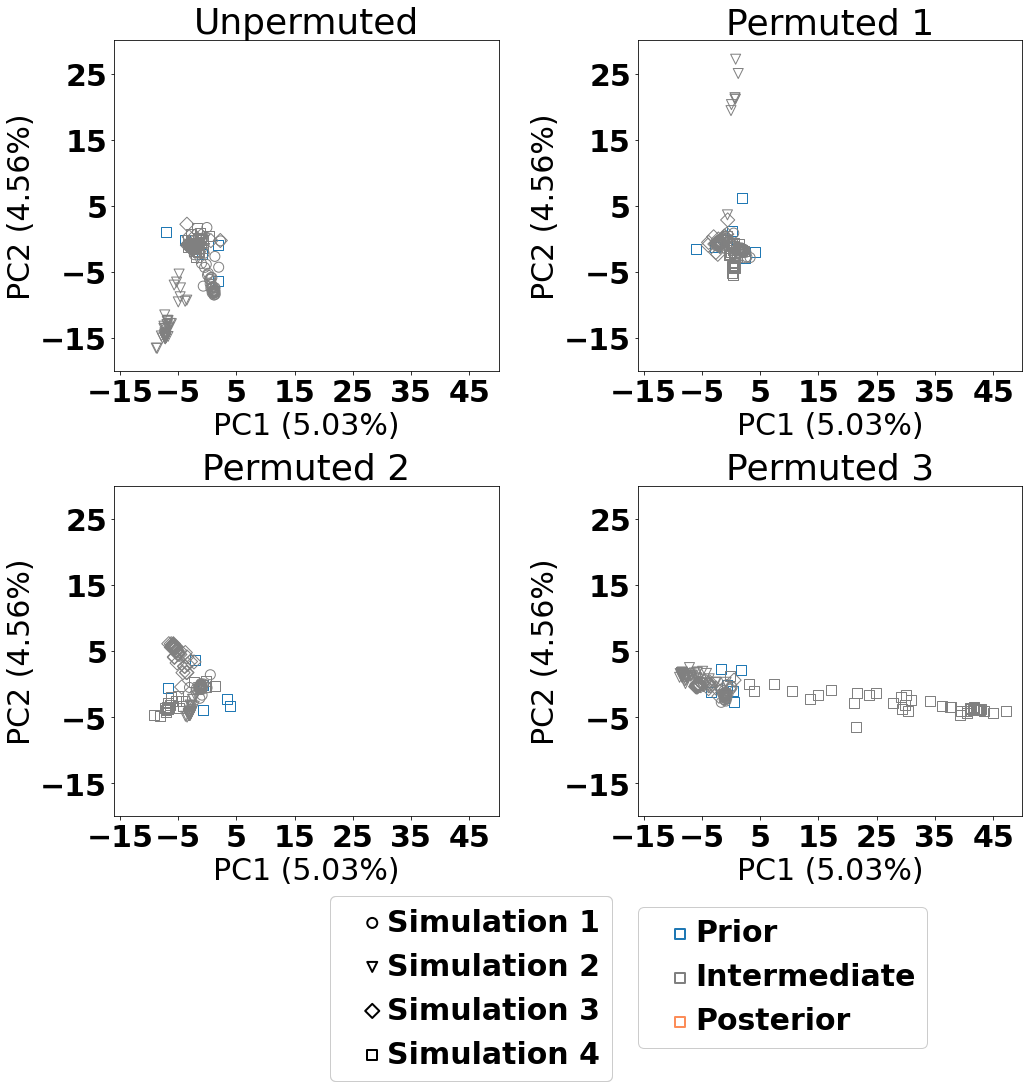

In [85]:
thinning_rng = np.random.default_rng(3052)
plt.figure(figsize=(15,15))
i = 1
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {0: 'o', 1: "v", 2: "D", 3: "s"} # Based on simulation number

# Each prior gets its own panel, but it still utilizes a single PCA ordination
for prior in proper_names.keys():
    plt.subplot(2,2,i)
    # Iterating over the four different simulations for the given prior
    for label in range(4):
        label_idxs = np.nonzero((simulation == label) & (prior == prior_name))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Prior"] = thinning_rng.choice(this_idxs["Prior"],size=min(len(this_idxs["Prior"]),10),replace=False)
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=min(len(this_idxs["Posterior"]),100),replace=False)
        print(label_idxs.shape)
        # plt.scatter(evo_PCS[:,0],evo_PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label== 0:
            plt.scatter(evo_PCS[this_idxs['Prior'],0],evo_PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(evo_PCS[this_idxs["Intermediate"],0],evo_PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=1,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(evo_PCS[this_idxs['Posterior'],0],evo_PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(evo_EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(evo_EV[1]*100))
    plt.xticks(np.arange(-15,50,10))
    plt.yticks(np.arange(-15,30,10))
    plt.xlim((-16,50))
    plt.ylim((-20,30))
    plt.title(proper_names[prior])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_simulation = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_simulation = plt.legend(handles_simulation, [f"Simulation {i + 1}" for i in range(4)], loc=(-.8,-.8), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_simulation)
plt.gcf().subplots_adjust(bottom=.22)
plt.savefig("../figures/evo_pca.png",dpi=300)
plt.show()

## Plotting generations

In [133]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [137]:
def draw_generation(this_prior_name,this_simulation,generation):
    this_population = evo_model_frame["population"].loc[(this_prior_name,this_simulation)][generation]
    points_to_pick = np.flatnonzero((this_prior_name == prior_name) & (this_simulation == simulation) & np.isin(particle_id,this_population) )
    plt.xticks(np.arange(-15,50,10))
    plt.yticks(np.arange(-15,30,10))
    plt.xlim((-16,50))
    plt.ylim((-20,30))
    plt.scatter(evo_PCS[points_to_pick,0],evo_PCS[points_to_pick, 1],
                    edgecolors='blue',alpha=1,marker="o",facecolors='none',s=100)

In [138]:
interact(draw_generation,
         this_prior_name = [("Unpermuted","unpermuted"),("Permuted 1","permuted_0"),
                            ("Permuted 2","permuted_1"),("Permuted 3","permuted_2")],
         this_simulation = [(1,0),(2,1),(3,2),(4,3)],
         generation = widgets.IntSlider(min=0,max=500,step=1,value=0)
        )

interactive(children=(Dropdown(description='this_prior_name', options=(('Unpermuted', 'unpermuted'), ('Permute…

<function __main__.draw_generation(this_prior_name, this_simulation, generation)>

# Effects on pathway level

In [40]:
aggregated_fva_res = load_pickle("../results/aggregated_fva_res.pkl")

In [41]:
'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'PDH': 'r_0961No1', 'FBA': 'r_0450No1', 'FCO': 'r_0438No1', 'PSP': 'r_0917No1', 'SHK': 'r_0997No1', 'GRW': 'r_2111'}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

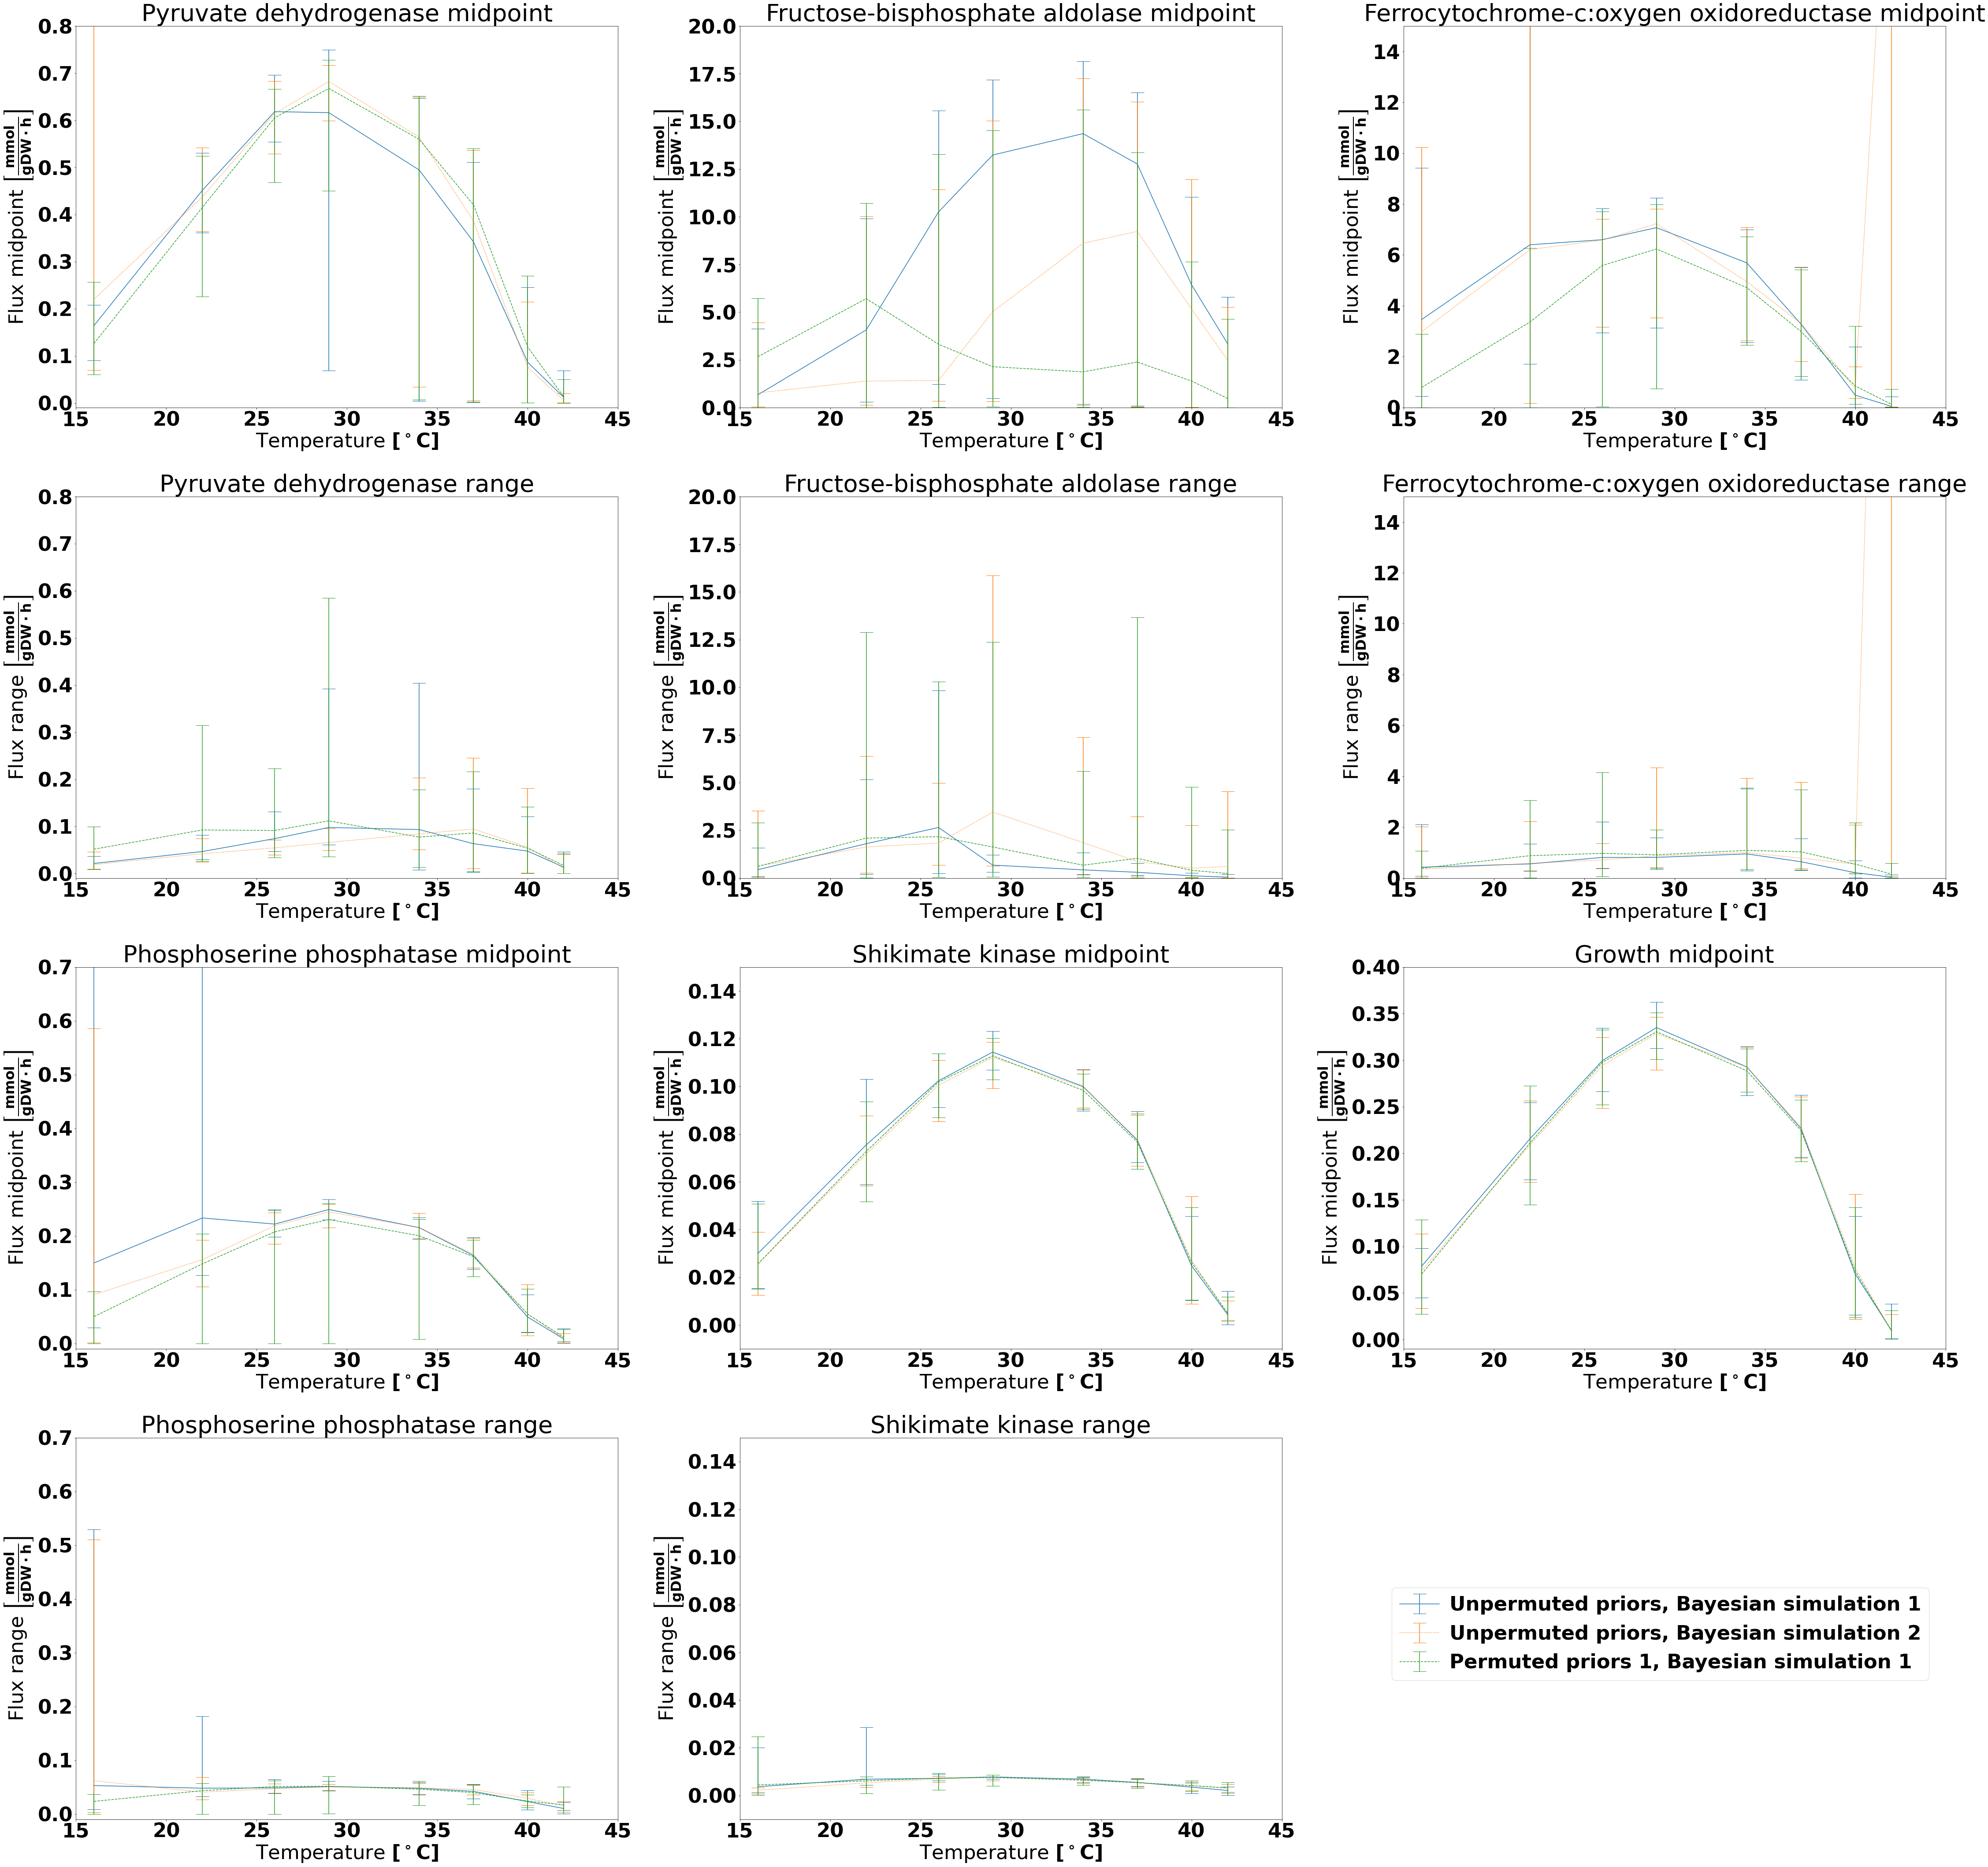

In [44]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Unpermuted priors, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="replicate",reaction=reaction, what=what, linestyle="dotted",condition="aerobic",label = "Unpermuted priors, Bayesian simulation 2")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="aerobic", label = "Permuted priors 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/aerobic_fva.pdf")

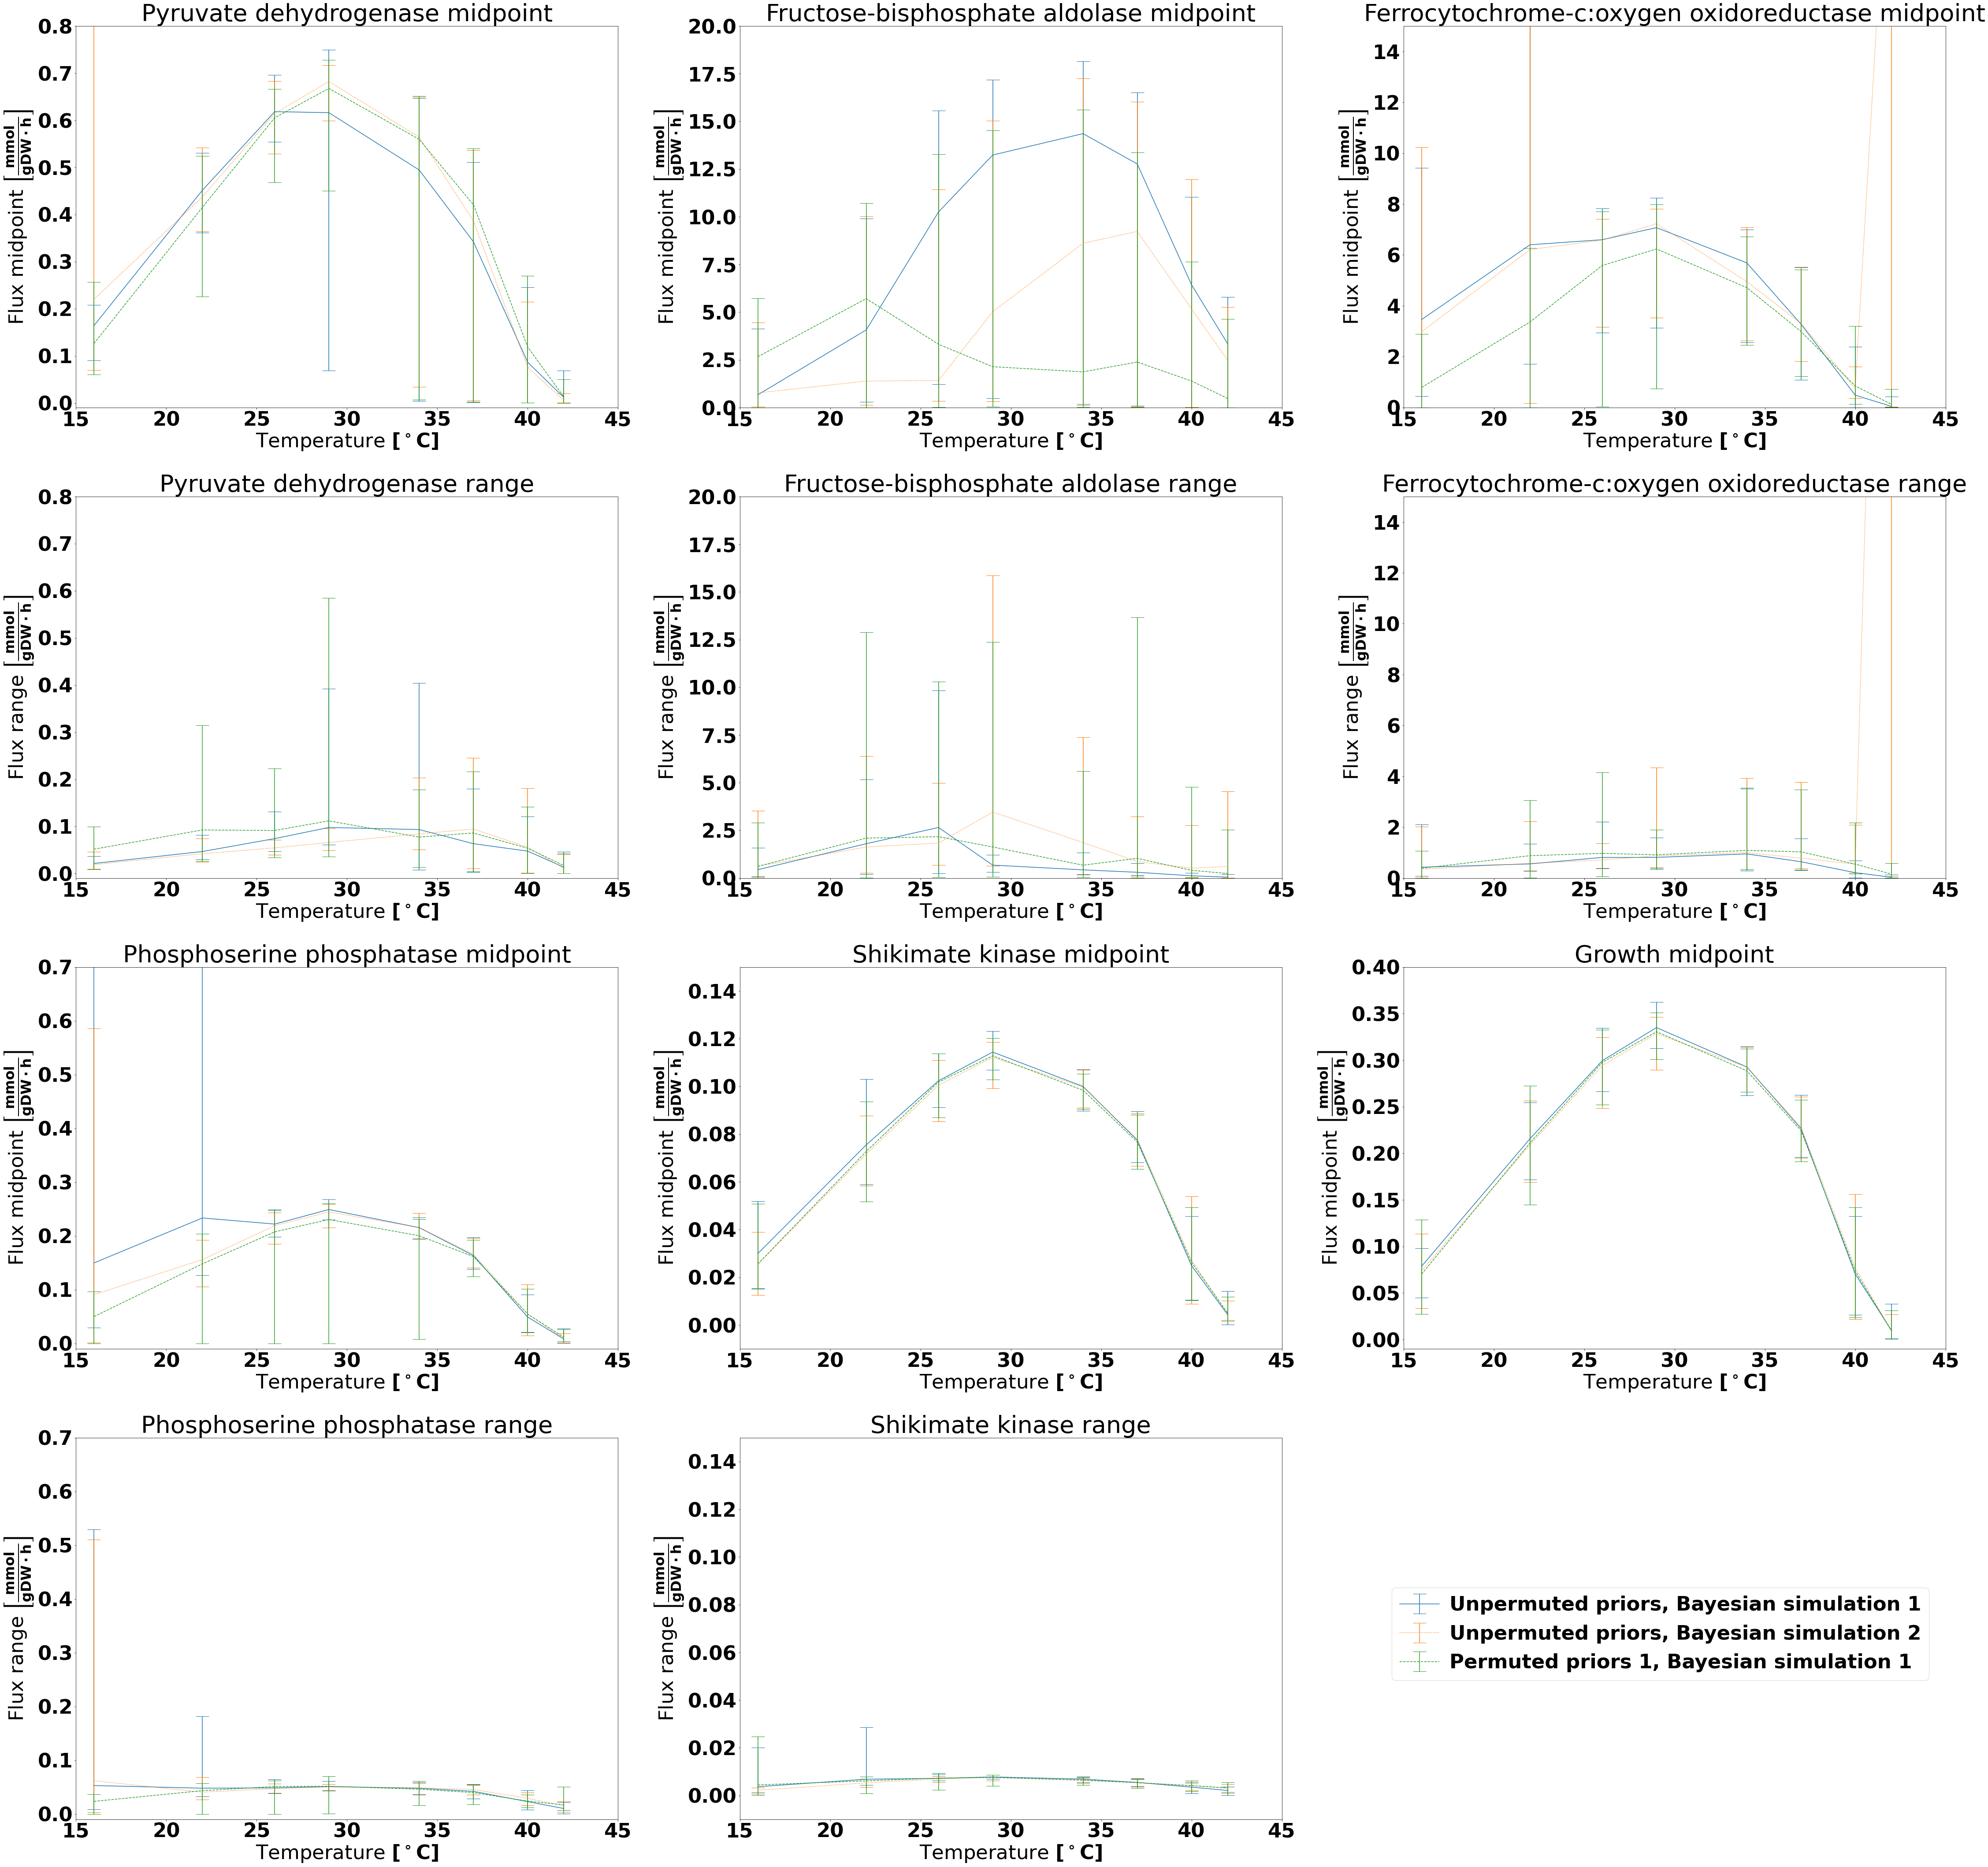

In [46]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Unpermuted priors, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="replicate",reaction=reaction, what=what, linestyle="dotted",condition="aerobic",label = "Unpermuted priors, Bayesian simulation 2")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="aerobic", label = "Permuted priors 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/anaerobic_fva.pdf")